# CS145: Project 3 | NCAA Win Prediction

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *JILL WELDON, jweldon*
* *TRAVIS SENF, tsenf*

## Project Overview

The main question that we are exploring as we investigate this dataset is: **what data, outside of the traditional box-score statistics, can be used to predict the outcome of an NCAA basketball game?**---

Examples of some of these non-box-score statistics include:
- the maturity of a team (underclassmen vs. upperclassmen)
- size of players on the team (height, weight, height-weight ratio)
- is it important to have players in each position

To start off this exploration, we will use a version of the most classic method of predicting basketball game outcomes: looking at each team's previous games. Many NBA game outcome predictors look at each team's records going into a game or the previous 3, 5, 10 games' outcomes for each team. Some of the best models for predicting NBA games clock in around 65-75% accuracy. Even though we want to look at non-box-score statistics and there may be some  correlation between winningness and team maturity, size, etc, it does not seem feasible to build a model solely based on these attributes. Therefore, we will start off with a model based on previous game statistics for each team -- averages over games played in the fourty-five days prior. Then, we will add in these non-box-score features to see if we are able to improve the accuracy with some more interesting data.

Our primary questions that we will explore in our visualizations are:
- Can we create our own model that predicts which team will win in a matchup?
- Can we supplement box-score statistics to make a highly accurate model?
- Is a player's BMI correlated with their skill level?
- Are players' roles (positions) as written in the box-score reflected in their box-score statistics?
- Is a player's maturity (class year) reflected in the box-score?

---


## Analysis of Dataset

---
### Dataset Summary
For this analysis, we are using the BigQuery public dataset on NCAA basketball. We are using the following tables in our analysis:
- `mbb_teams_games_sr` (95.36 MB): Team box-score data for every men's NCAA basketball game between the 2013-2014 and 2017-2018 seasons
- `mbb_players_games_sr` (421.03 MB): Player box-score data for every men's NCAA basketball game between the 2013-2014 and 2017-2018 seasons

Total Dataset Size: 516.39 *MB*

----

### Teams' Games Table: `mbb_teams_games_sr` 
This table contains box-score data and other information about NCAA basketball games. There are 59,610 rows, each representing a different game that was played. There are 132 columns with the first chunk containing data about the game's logistics such as: `scheduled_date`, `gametime`, `conference_game`, information about the venue, the team's conferences, divisions, logos, and identifiers. The rest of the table contains traditional basketball box-score statistics about the game for each of the two teams (points, rebounds, assists, steals, fouls, etc.)

### Players' Games Table: `mbb_players_games_sr`
This table contains player-level box-score data separated by game about NCAA men's basketball games. There are 888,844 rows in this table each one containing individual player data from each game they were on the roster. There are 66 columns in this table with the first half containing game logistics, like that provided in `mbb_teams_games_sr`. Then, this table moves onto the player's information such as their name, `jersey_number`, information about their birthplace, team, and school. Finally, the table gets into the player's box-score statistics from the game this row is for, starting off with whether or not the player was active, played, and started and finishing with the rest of the recorded box-score data.

### Relating the Tables
These tables can be connected by the key `team_id` or `game_id`. In order to aggregate player data for a team, we use `team_id` in some of our queries such as finding a team's average BMI. Aggregating player data for a team in a certain game needs to relate the tables by both `team_id` and `game_id`. An example of a query that would need both of these is our query that looks at team's BMI and predicting if they will win. This needs to aggregate data by team and needs winning data that is only in the `mbb_teams_games_sr` table also needs player height and weight that is only ofund in the `mbb_players_games_sr` table. 

## Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "proj3-370920"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

import matplotlib.pyplot as plt


### Improving Statistics w/Age
We summed up different statistcs by class year to see if / how players change as they get older and gain experience playing college basketball. First, we took a look to see the spread of average playing time by class. This visualization shows us that there is a clear increase in average minutes played as players get older. This was expected but good to check on. When we look at the rest of the box-score statistics, we calculate the classes' average statistics per game divided by the average number of minutes played per game and multiply by 40 since that's how many minutes are in a regulation game. Therefore, we are looking at a player's projected stats if they played at their current level of production for 40 minutes, so that players with more playing time are not overrepresented.

In [ ]:
%%bigquery class_minutes --project $project_id 

SELECT class, AVG(minutes_int64) AS minutes
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
WHERE class IS NOT NULL AND class != ""  # should include when players do not play?
GROUP BY class
ORDER BY minutes DESC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Minutes per Game')

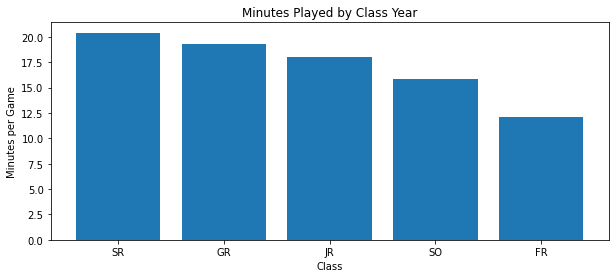

In [ ]:
plt.figure(figsize=(10,4)) 
plt.bar(class_minutes["class"], class_minutes["minutes"])
plt.title("Minutes Played by Class Year")
plt.xlabel("Class")
# plt.ylim([10,25])
plt.ylabel("Minutes per Game")

In [ ]:
# CLASSES RANKED BY DIFFERENT STATISTICS SEE WHICH DETERMINE MATURITY
# AVG height to weight ratio on team impact winningness?
%%bigquery class_turnovers --project $project_id 

# IMMATURE
SELECT class, AVG(turnovers)*40 / AVG(minutes_int64) AS turnovers
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
WHERE class IS NOT NULL AND class != ""
GROUP BY class
ORDER BY turnovers DESC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Turnovers per 40 Minutes')

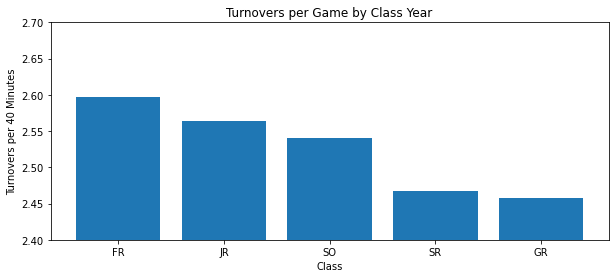

In [ ]:
plt.figure(figsize=(10,4)) 
plt.bar(class_turnovers["class"], class_turnovers["turnovers"])
plt.title("Turnovers per Game by Class Year")
plt.xlabel("Class")
plt.ylim([2.4, 2.7])
# plt.xticks(rotation=90)
plt.ylabel("Turnovers per 40 Minutes")

In [ ]:
%%bigquery class_fouls --project $project_id 

SELECT class, AVG(personal_fouls)*40 / AVG(minutes_int64) AS fouls
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
WHERE class IS NOT NULL AND class != ""
GROUP BY class
ORDER BY fouls DESC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Fouls per 40 minutes')

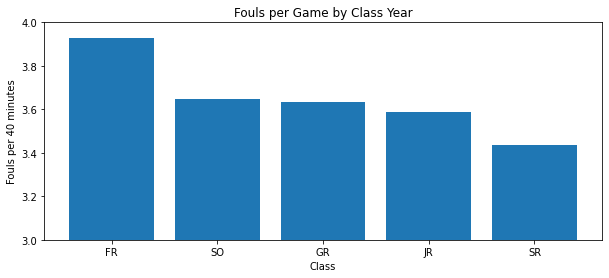

In [ ]:
plt.figure(figsize=(10,4)) 
plt.bar(class_fouls["class"], class_fouls["fouls"])
plt.title("Fouls per Game by Class Year")
plt.xlabel("Class")
plt.ylim([3, 4])
plt.ylabel("Fouls per 40 minutes")

In [ ]:
%%bigquery class_points --project $project_id 

# MATURE
SELECT class, (AVG(points)*40)/AVG(minutes_int64) AS points
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
WHERE class IS NOT NULL AND class != ""
GROUP BY class
ORDER BY points DESC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Points per 40 minutes')

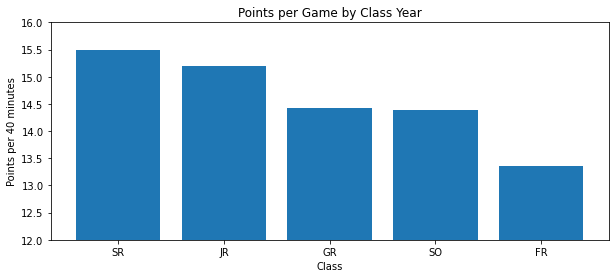

In [ ]:
plt.figure(figsize=(10,4)) 
plt.bar(class_points["class"], class_points["points"])
plt.title("Points per Game by Class Year")
plt.xlabel("Class")
plt.ylim([12, 16])
plt.ylabel("Points per 40 minutes")

In [ ]:
%%bigquery class_assists --project $project_id 

# MATURE
SELECT class, (AVG(assists)*40)/AVG(minutes_int64) AS assists
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
WHERE class IS NOT NULL AND class != ""
GROUP BY class
ORDER BY assists DESC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Assists per 40 minutes')

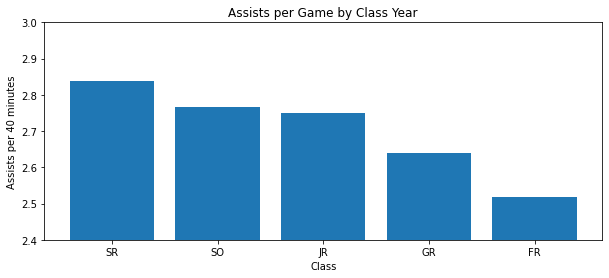

In [ ]:
plt.figure(figsize=(10,4)) 
plt.bar(class_assists["class"], class_assists["assists"])
plt.title("Assists per Game by Class Year")
plt.xlabel("Class")
plt.ylim([2.4, 3])
plt.ylabel("Assists per 40 minutes")

The above bar graphs demonstrate correlation between player improvement and age when looking at Freshmen, Sophomores, Juniors, and Seniors. The graduate student bar moves around a bit, possibly because there are much fewer graduate players than any other year so the data for that class is more variable. When evaluating the implications of these visualizaitons, we will ignore the 'GR' bar for graduate students. Fouls and turnovers are box-score statistcs that reflect negatively on a player when they are higher. For both of these statistics, Freshmen have the highest average value and Seniors have the lowest. Whereas points and assists are positive statistics to have high values for and in the displays above, seniors have the highest average and freshmen have the lowest. This can be attributed to higher levels of maturity, as players that are more in control and understand the game more can avoid picking up these negative statistics. We also generally see an increase in assists and points as the grade level of a player increases, showing that as a player gets older, their ability to help their team score against opposing defenses gets better. 

### Player Height, Weight, BMI vs. Statistics
We decided to take a look at the correlation between player size and their box-score statistics. We used height to weight ratio as 'BMI'. 

In [ ]:
%%bigquery player_data --project $project_id 


SELECT 
  DISTINCT(full_name), 
  AVG(weight / height) AS bmi, 
  AVG(height) AS height, 
  AVG(weight) AS weight, 
  (SUM(points) * 40) / SUM(minutes_int64) AS points_per_40, 
  (SUM(steals) * 40) / SUM(minutes_int64) AS steals_per_40,
  (SUM(offensive_rebounds) * 40) / SUM(minutes_int64) AS o_rebounds_per_40,
  (SUM(defensive_rebounds) * 40) / SUM(minutes_int64) AS d_rebounds_per_40,
  (SUM(rebounds) * 40) / SUM(minutes_int64) AS rebounds_per_40,
  (SUM(blocks) * 40) / SUM(minutes_int64) AS blocks_per_40,
  (SUM(assists) * 40) / SUM(minutes_int64) AS assists_per_40,
  (SUM(personal_fouls) * 40) / SUM(minutes_int64) AS fouls_per_40,
  (SUM(two_points_made) * 40) / SUM(minutes_int64) AS twos_made_per_40,
  (SUM(three_points_made) * 40) / SUM(minutes_int64) AS threes_made_per_40,
  (SUM(two_points_att) * 40) / SUM(minutes_int64) AS twos_att_per_40,
  (SUM(three_points_att) * 40) / SUM(minutes_int64) AS threes_att_per_40,
  AVG(two_points_pct) AS twos_pct,
  AVG(three_points_pct) AS threes_pct,
  (SUM(free_throws_made) * 40) / SUM(minutes_int64) AS ft_made_per_40,
  (SUM(free_throws_att) * 40) / SUM(minutes_int64) AS ft_att_per_40,
  AVG(free_throws_pct) AS ft_pct,
  SUM(minutes_int64) as mins
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
WHERE minutes_int64 > 10
AND minutes_int64 IS NOT NULL
AND height IS NOT NULL
AND height != 0
GROUP BY full_name


Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Blocks per 40 Minutes')

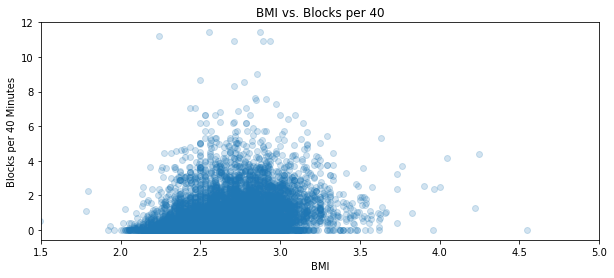

In [ ]:
plt.figure(figsize=(10,4)) 
plt.scatter(player_data["bmi"], player_data["blocks_per_40"], alpha=0.2)
plt.title("BMI vs. Blocks per 40")
plt.xlabel("BMI")
plt.xlim([1.5,5])
# plt.ylim([0,5])
plt.ylabel("Blocks per 40 Minutes")

Text(0, 0.5, 'Steals per 40 minutes')

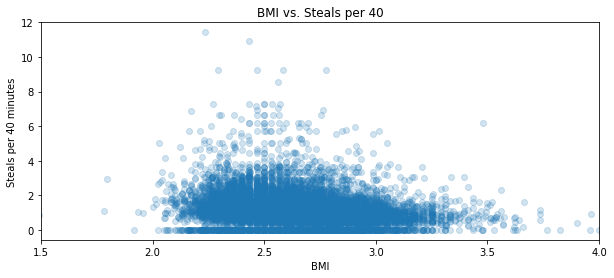

In [ ]:
plt.figure(figsize=(10,4)) 
plt.scatter(player_data["bmi"], player_data["steals_per_40"], alpha=0.2)
plt.title("BMI vs. Steals per 40")
plt.xlabel("BMI")
plt.xlim([1.5,4])
# plt.ylim([0,5])
plt.ylabel("Steals per 40 minutes")

Text(0, 0.5, 'Rebounds per 40 minutes')

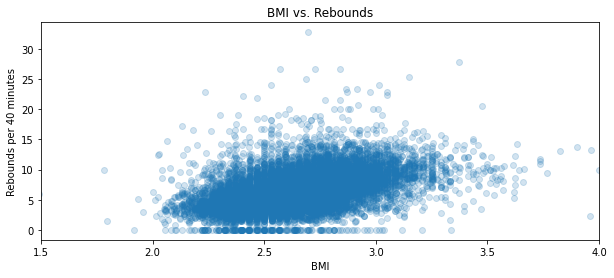

In [ ]:
plt.figure(figsize=(10,4)) 
plt.scatter(player_data["bmi"], player_data["rebounds_per_40"], alpha=0.2)
plt.title("BMI vs. Rebounds")
plt.xlabel("BMI")
plt.xlim([1.5,4])
# plt.ylim([0,5])
plt.ylabel("Rebounds per 40 minutes")

We can see that overall, having a higher ratio of weight to height correlates to getting more blocks and rebounds, which makes sense due to the fact that typically, taller players tend to have a higher height to weight ratio, and additionally, stronger players have a higher chance of being able to wrestle a rebound away from other players, or hold their ground enough to block a shot. It makes sense then, that players with a lower ratio would be more proficient at stealing, which requires more agility, and typically favors shorter players.

### Box-Score Statistics vs. Position

In [ ]:
%%bigquery position_data --project $project_id 

SELECT
  primary_position,
  AVG(weight / height) AS bmi, 
  AVG(height) AS height, 
  AVG(weight) AS weight, 
  (SUM(points) * 40) / SUM(minutes_int64) AS points_per_40, 
  (SUM(steals) * 40) / SUM(minutes_int64) AS steals_per_40,
  (SUM(offensive_rebounds) * 40) / SUM(minutes_int64) AS o_rebounds_per_40,
  (SUM(defensive_rebounds) * 40) / SUM(minutes_int64) AS d_rebounds_per_40,
  (SUM(rebounds) * 40) / SUM(minutes_int64) AS rebounds_per_40,
  (SUM(blocks) * 40) / SUM(minutes_int64) AS blocks_per_40,
  (SUM(assists) * 40) / SUM(minutes_int64) AS assists_per_40,
  (SUM(personal_fouls) * 40) / SUM(minutes_int64) AS fouls_per_40,
  (SUM(two_points_made) * 40) / SUM(minutes_int64) AS twos_made_per_40,
  (SUM(three_points_made) * 40) / SUM(minutes_int64) AS threes_made_per_40,
  (SUM(two_points_att) * 40) / SUM(minutes_int64) AS twos_att_per_40,
  (SUM(three_points_att) * 40) / SUM(minutes_int64) AS threes_att_per_40,
  (SUM(two_points_pct) * 40) / SUM(minutes_int64) AS twos_pct_per_40,
  (SUM(three_points_pct) * 40) / SUM(minutes_int64) AS threes_pct_per_40,
  (SUM(free_throws_made) * 40) / SUM(minutes_int64) AS ft_made_per_40,
  (SUM(free_throws_att) * 40) / SUM(minutes_int64) AS ft_att_per_40,
  (SUM(free_throws_pct) * 40) / SUM(minutes_int64) AS ft_pct_per_40,
  SUM(minutes_int64) as mins
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
WHERE minutes_int64 > 5
  AND minutes_int64 IS NOT NULL
  AND height IS NOT NULL
  AND height != 0
  AND primary_position != "NA"
GROUP BY primary_position


Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Blocks per 40')

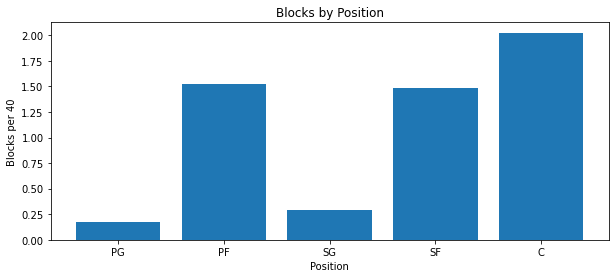

In [ ]:
plt.figure(figsize=(10,4)) 
plt.bar(position_data["primary_position"], position_data["blocks_per_40"])
plt.title("Blocks by Position")
plt.xlabel("Position")
plt.ylabel("Blocks per 40")

Text(0, 0.5, 'Steals per 40')

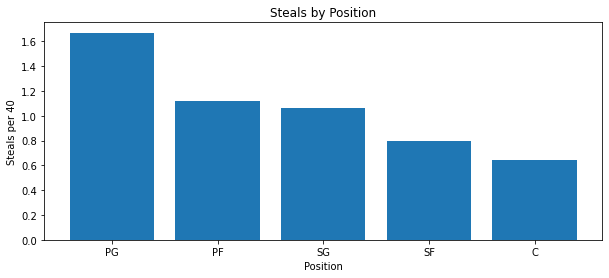

In [ ]:


plt.figure(figsize=(10,4)) 
plt.bar(position_data["primary_position"], position_data["steals_per_40"])
plt.title("Steals by Position")
plt.xlabel("Position")
plt.ylabel("Steals per 40")


Text(0, 0.5, 'Assists per 40')

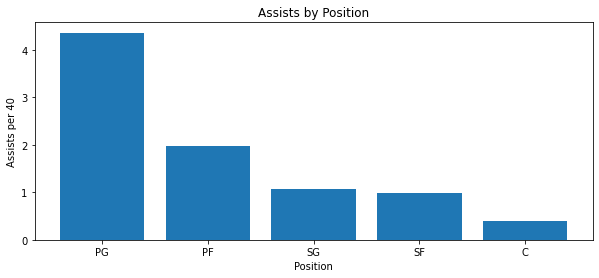

In [ ]:

plt.figure(figsize=(10,4)) 
plt.bar(position_data["primary_position"], position_data["assists_per_40"])
plt.title("Assists by Position")
plt.xlabel("Position")
plt.ylabel("Assists per 40")

Text(0, 0.5, 'Rebounds per 40')

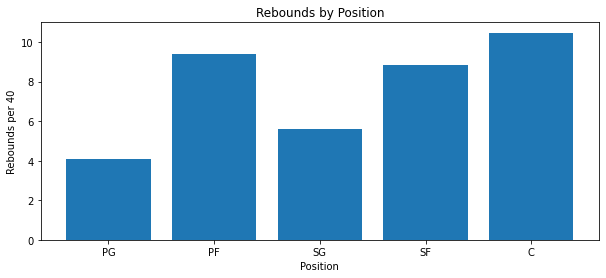

In [ ]:


plt.figure(figsize=(10,4)) 
plt.bar(position_data["primary_position"], position_data["rebounds_per_40"])
plt.title("Rebounds by Position")
plt.xlabel("Position")
plt.ylabel("Rebounds per 40")

Text(0, 0.5, 'Fouls per 40')

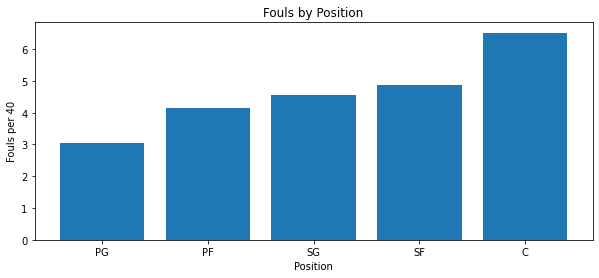

In [ ]:


plt.figure(figsize=(10,4)) 
plt.bar(position_data["primary_position"], position_data["fouls_per_40"])
plt.title("Fouls by Position")
plt.xlabel("Position")
plt.ylabel("Fouls per 40")


Text(0, 0.5, 'Height (in)')

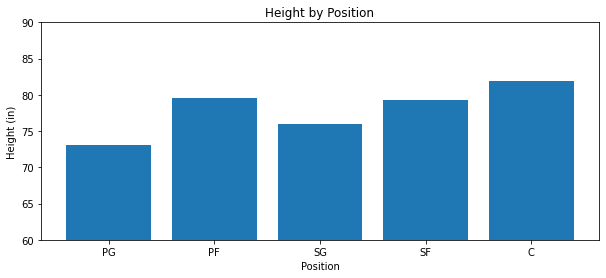

In [ ]:
plt.figure(figsize=(10,4)) 
plt.bar(position_data["primary_position"], position_data["height"])
plt.title("Height by Position")
plt.xlabel("Position")
plt.ylim([60, 90])
plt.ylabel("Height (in)")

Text(0, 0.5, 'Weight (lbs)')

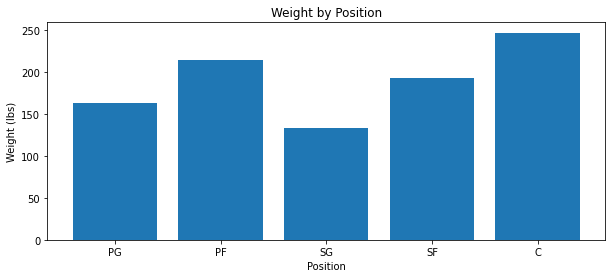

In [ ]:

plt.figure(figsize=(10,4)) 
plt.bar(position_data["primary_position"], position_data["weight"])
plt.title("Weight by Position")
plt.xlabel("Position")
plt.ylabel("Weight (lbs)")

Text(0, 0.5, 'Threes per 40')

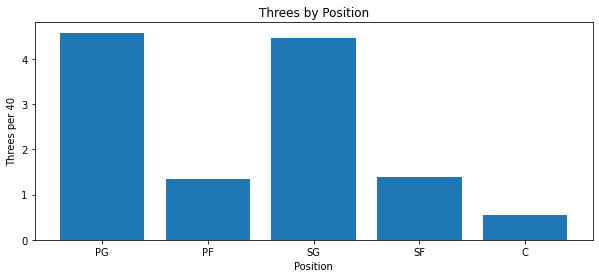

In [ ]:

plt.figure(figsize=(10,4)) 
plt.bar(position_data["primary_position"], position_data["threes_att_per_40"])
plt.title("Threes by Position")
plt.xlabel("Position")
plt.ylabel("Threes per 40")

Text(0, 0.5, 'Two-Pointers per 40')

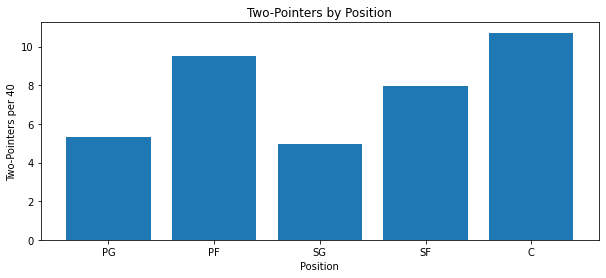

In [ ]:

plt.figure(figsize=(10,4)) 
plt.bar(position_data["primary_position"], position_data["twos_att_per_40"])
plt.title("Two-Pointers by Position")
plt.xlabel("Position")
plt.ylabel("Two-Pointers per 40")

We can see a lot of trends that we would expect by position. The larger positions, such as the center, power forward, and small forward, tend to shoot more 2 point shots, weigh more, are taller, rebound more, and block more shots. The smaller positions, such as point guard and shooting guard, shoot more three point shots, and specifically the point guard, who is in charge of handling the ball, and guarding the opposing teams ball handler, has the most steals and assists. Interestingly, power forwards have more assists, steal the ball more, and foul less than their other "big man" counterparts, which shows that the power forward position is typically occupied by larger players that have skillsets that more closely resemble a guard. Finally, we see centers dominate the foul column, as they are typically assigned as the defender of last resort when the other team gets close to the basket.

### What positions lead to winning?

This leads to a conversation about what roles on a successful team are burdened with the majority of the point scoring for the team. In our dataset, the volume of data per team on "primary position" was too sparse, so we had to use a data column "position" that was more populated, but was less specific in its application. This column had another problem, however, in that almost every player was classified as either "F" for forward or "G" for guard, and few got special distinctions, like "G-F" or "F-C". Even "C" for center was rarely assigned to players. For that reason, it is only really helpful to analyze forward vs guard, and then the other 3 against each other. 

In [ ]:
%%bigquery position_points --project $project_id 

SELECT p.team_id, p.season, wins, center_pts, guard_pts, forward_pts, guard_forward_pts, forward_center_pts
FROM `bigquery-public-data.ncaa_basketball.mbb_historical_teams_seasons` as teams
INNER JOIN (SELECT team_id, season,
    SUM(IF(position = "C", points, 0)) / SUM(points) AS center_pts,
    SUM(IF(position = "G", points, 0)) / SUM(points) AS guard_pts,
    SUM(IF(position = "F", points, 0)) / SUM(points) AS forward_pts,
    SUM(IF(position = "G-F", points, 0)) / SUM(points) AS guard_forward_pts,
    SUM(IF(position = "F-C", points, 0)) / SUM(points) AS forward_center_pts,
    FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
    WHERE position IS NOT NULL AND points IS NOT NULL AND points != 0
    GROUP BY team_id, season) AS p
ON teams.team_id = p.team_id AND teams.season = p.season
ORDER BY wins DESC

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Center Points')

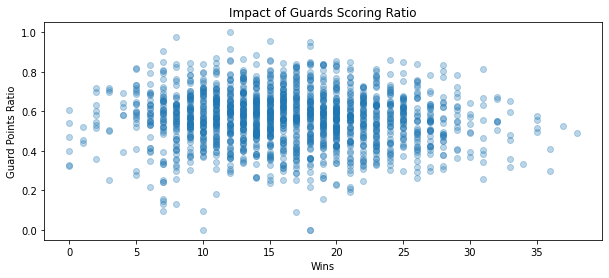

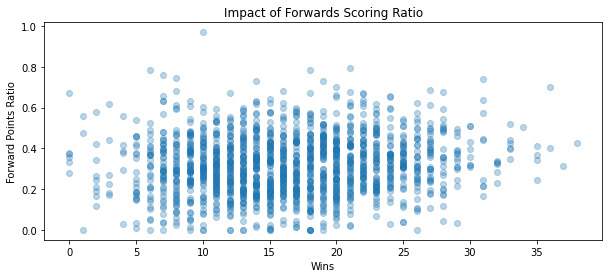

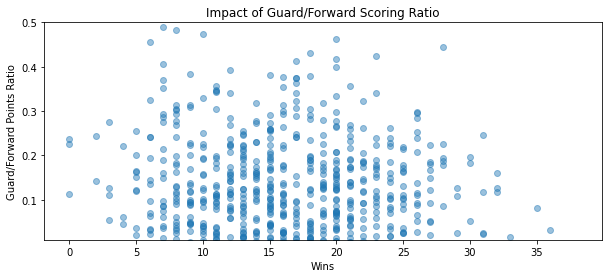

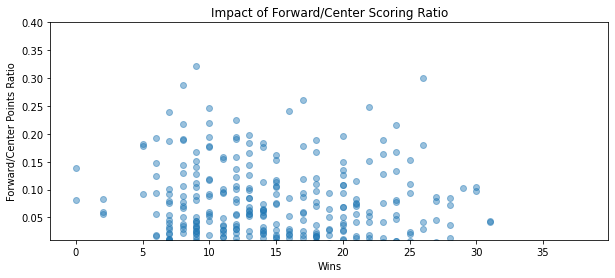

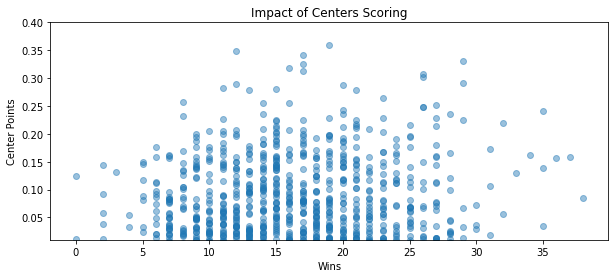

In [ ]:
plt.figure(figsize=(10,4)) 
plt.scatter(position_points["wins"], position_points["guard_pts"], alpha = 0.3)
plt.title("Impact of Guards Scoring Ratio")
plt.xlabel("Wins")
# plt.xlim([0,100])
# plt.ylim([0,15])
plt.ylabel("Guard Points Ratio")

plt.figure(figsize=(10,4)) 
plt.scatter(position_points["wins"], position_points["forward_pts"], alpha = 0.3)
plt.title("Impact of Forwards Scoring Ratio")
plt.xlabel("Wins")
# plt.xlim([0,100])
# plt.ylim([0,15])
plt.ylabel("Forward Points Ratio")

plt.figure(figsize=(10,4)) 
plt.scatter(position_points["wins"], position_points["guard_forward_pts"], alpha = 0.45)
plt.title("Impact of Guard/Forward Scoring Ratio")
plt.xlabel("Wins")
# plt.xlim([0,100])
plt.ylim([0.01,0.5])
plt.ylabel("Guard/Forward Points Ratio")

plt.figure(figsize=(10,4)) 
plt.scatter(position_points["wins"], position_points["forward_center_pts"], alpha = 0.45)
plt.title("Impact of Forward/Center Scoring Ratio")
plt.xlabel("Wins")
# plt.xlim([0,100])
plt.ylim([0.01,0.4])
plt.ylabel("Forward/Center Points Ratio")

plt.figure(figsize=(10,4)) 
plt.scatter(position_points["wins"], position_points["center_pts"], alpha = 0.45)
plt.title("Impact of Centers Scoring")
plt.xlabel("Wins")
# plt.xlim([0,100])
plt.ylim([0.01,0.4])
plt.ylabel("Center Points")

From this, we can maybe see a slight correlation in the negative direction for guards as wins increase, and a slight increase in forward point burden. This makes sense, as in college, the more dominant players are typically the ones that physically outclass their opponents and are ready for the NBA level, and NBA players tend to be larger than their college counterparts at the same position, causing some NBA caliber players to be categorized as a position larger than normal at the college level. It goes without saying that having more NBA caliber players will likely lead to more wins. As for the other 3 categories, there simply isn't a consistent enough classification for players at these positions to see significant correlation.

Next, we look at how scoring participation from various ages of teammates contributes to winning teams. Initially, we expected the older classes to contribute and score more due to the difference in maturity and age, but we also realized that many NBA-caliber players only play their freshman year, and then go to the NBA, and these players typically play in prestigious, high win programs.

In [ ]:
%%bigquery grade_points --project $project_id 

WITH class AS (SELECT team_id, season,
    SUM(IF(class = "FR", points, 0)) / SUM(points) AS fr_min,
    SUM(IF(class = "SO", points, 0)) / SUM(points) AS so_min,
    SUM(IF(class = "JR", points, 0)) / SUM(points) AS jr_min,
    SUM(IF(class = "SR", points, 0)) / SUM(points) AS sr_min,
    SUM(IF(class = "GR", points, 0)) / SUM(points) AS gr_min,
    FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
    WHERE class IS NOT NULL AND points IS NOT NULL AND points != 0
    GROUP BY team_id, season),

wins AS (SELECT team_id, season, SUM(IF (win, 1, 0)) as win
FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr`
GROUP BY team_id, season)

SELECT wins.team_id, wins.season, win, fr_min, so_min, jr_min, sr_min, gr_min
FROM wins
JOIN class
ON wins.season = class.season AND wins.team_id = class.team_id
WHERE win > 0

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Grad Court Participation')

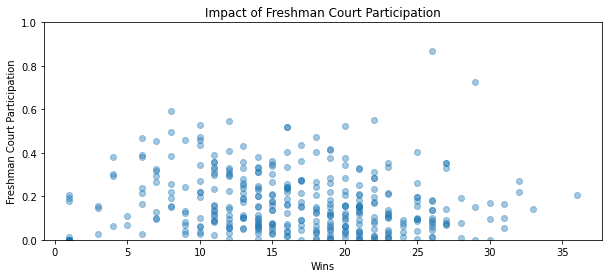

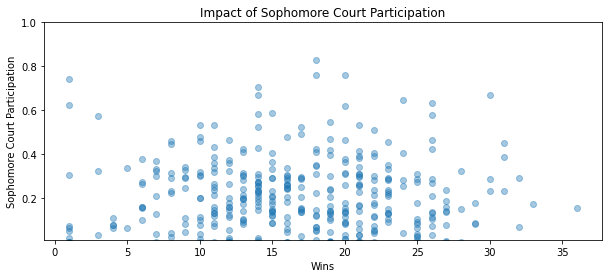

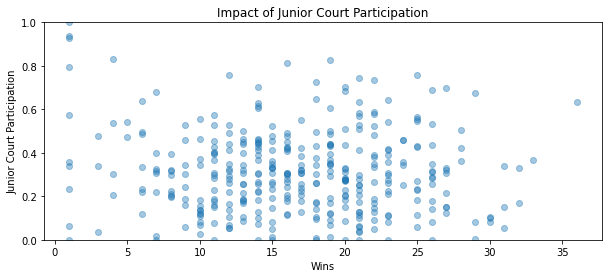

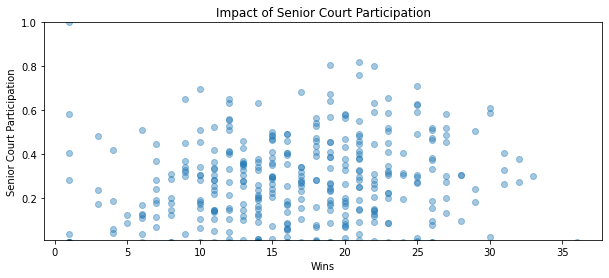

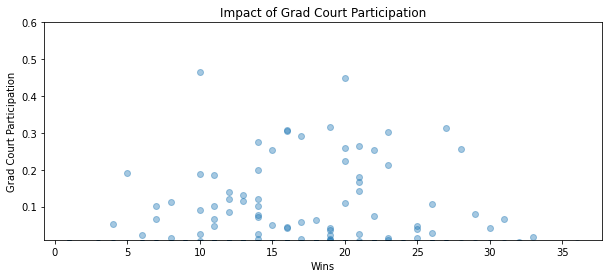

In [ ]:
plt.figure(figsize=(10,4)) 
plt.scatter(grade_points["win"], grade_points["fr_min"], alpha = 0.4)
plt.title("Impact of Freshman Court Participation")
plt.xlabel("Wins")
# plt.xlim([0,100])
plt.ylim([0,1])
plt.ylabel("Freshman Court Participation")

plt.figure(figsize=(10,4)) 
plt.scatter(grade_points["win"], grade_points["so_min"], alpha = 0.4)
plt.title("Impact of Sophomore Court Participation")
plt.xlabel("Wins")
# plt.xlim([0,100])
plt.ylim([0.01,1])
plt.ylabel("Sophomore Court Participation")

plt.figure(figsize=(10,4)) 
plt.scatter(grade_points["win"], grade_points["jr_min"], alpha = 0.4)
plt.title("Impact of Junior Court Participation")
plt.xlabel("Wins")
# plt.xlim([0,100])
plt.ylim([0,1])
plt.ylabel("Junior Court Participation")

plt.figure(figsize=(10,4)) 
plt.scatter(grade_points["win"], grade_points["sr_min"], alpha = 0.4)
plt.title("Impact of Senior Court Participation")
plt.xlabel("Wins")
# plt.xlim([0,100])
plt.ylim([0.01, 1])
plt.ylabel("Senior Court Participation")

plt.figure(figsize=(10,4)) 
plt.scatter(grade_points["win"], grade_points["gr_min"], alpha = 0.4)
plt.title("Impact of Grad Court Participation")
plt.xlabel("Wins")
# plt.xlim([0,100])
plt.ylim([0.01,0.6])
plt.ylabel("Grad Court Participation")

It seems, however, that our initial thoughts were correct. Higher win programs seem to rely on their freshmen players less and less, and the prevailance of "one and done" players simply isn't enough in the vast college basketball landscape. As we expected, higher win programs have higher scoring participation from their senior players, with graduate students not showing much correlation due to the low volume of those players. The reliance on sophomores and juniors tends to not change much as we look at teams at different levels, which makes sense, since their distributions seem to mirror a "middle ground" between freshmen and seniors.

One note about the database that impacted our ability to analyze data was the overlap between different tables in the database. A large majority of the data we found on a team in one table would be absent in another table, so we had a large amount of data that was lost due to the inability to link data between the tables. This is seen most clearly in the previous section, which has much fewer data points than position table due to inability to correlate tables with keys. Also, even though it had lots of historical data, the table mbb_historical_teams_seasons had strange gaps in the most recent years of the database, so we could only use it sparingly. 

### Example Model: Predicting the outcome of a game based off stats from games in the last 45 days.

In [ ]:
## CREATE DATASET TO STORE MODEL
model_dataset_name = 'win_prediction'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Before using our engineered variables, we wanted to see if just looking at past game performance could give us insight into who would win. To do this, we compiled various stats that we thought contributed to winning, such as points scored, field goal percentage, and offensive rebounding, to establish a baseline of performance for our predictive algorithm later. To do this, for a given game, we compiled the average of the statistics from games within 45 days previous to the game, and used that as our model parameters.

In [ ]:
## SIMPLE WIN MODEL

%%bigquery --project $project_id

CREATE OR REPLACE MODEL `win_prediction.simple_win_model`
OPTIONS(model_type='logistic_reg') AS

WITH g AS (SELECT t.scheduled_date, IF(t.points_game > t.opp_points_game, 1, 0) as res, 
t.game_id, t.team_id as home, t.opp_id as opp, s.team_id, s.opp_id, s.scheduled_date, 
pt, opt, fgpct, ofgpct, tpt, otpt, rb, orb, atr, oatr, pot, opot, tov, otov
      FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` as t 
      JOIN (SELECT scheduled_date, team_id, opp_id, points_game as pt, 
            opp_points_game as opt, field_goals_pct as fgpct, opp_field_goals_pct as ofgpct, 
            three_points_pct as tpt, opp_three_points_pct as otpt, offensive_rebounds as rb, 
            opp_offensive_rebounds as orb, assists_turnover_ratio as atr, opp_assists_turnover_ratio as oatr, 
            points_off_turnovers as pot, opp_points_off_turnovers as opot, turnovers as tov, 
            opp_turnovers as otov
            FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr`
            WHERE field_goals_pct IS NOT NULL
            AND opp_field_goals_pct IS NOT NULL) as s
      ON (s.scheduled_date >= DATE_ADD(t.scheduled_date, INTERVAL -45 DAY))
      AND (s.scheduled_date < t.scheduled_date)
      AND (t.team_id = s.team_id OR t.opp_id = s.opp_id)
      WHERE season < 2017
      )
      
SELECT res as Label, AVG(pt) as pt, AVG(opt) as opt, AVG(fgpct) as fgpct, AVG(ofgpct) as ofgpct, 
AVG(tpt) as tpt, AVG(otpt) as otpt, AVG(rb) as orb, AVG(orb) as oorb, AVG(atr) as atr, 
AVG(oatr) as oatr, AVG(pot)*AVG(otov) as stotov, AVG(opot)*AVG(tov) osttotov
FROM g
GROUP BY game_id, res 

Query is running:   0%|          |

""


In [ ]:
## TRAINING MODEL STATS
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `win_prediction.simple_win_model`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,3,0.658941,0.655246,1.6,3477
1,0,2,0.663153,0.660443,0.8,3639
2,0,1,0.673348,0.671871,0.4,3881
3,0,0,0.684713,0.684161,0.2,3098


In [ ]:
## SIMPLE WIN MODEL EVALUATION

%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `win_prediction.simple_win_model`, (
    WITH g AS (SELECT t.scheduled_date, IF(t.points_game > t.opp_points_game, 1, 0) as res, 
    t.game_id, t.team_id as home, t.opp_id as opp, s.team_id, s.opp_id, s.scheduled_date, 
pt, opt, fgpct, ofgpct, tpt, otpt, rb, orb, atr, oatr, pot, opot, tov, otov
      FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` as t 
      JOIN (SELECT scheduled_date, team_id, opp_id, points_game as pt, 
            opp_points_game as opt, field_goals_pct as fgpct, opp_field_goals_pct as ofgpct, 
            three_points_pct as tpt, opp_three_points_pct as otpt, offensive_rebounds as rb, 
            opp_offensive_rebounds as orb, assists_turnover_ratio as atr, opp_assists_turnover_ratio as oatr, 
            points_off_turnovers as pot, opp_points_off_turnovers as opot, turnovers as tov, 
            opp_turnovers as otov
            FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr`
            WHERE field_goals_pct IS NOT NULL
            AND opp_field_goals_pct IS NOT NULL) as s
      ON (s.scheduled_date >= DATE_ADD(t.scheduled_date, INTERVAL -45 DAY))
      AND (s.scheduled_date < t.scheduled_date)
      AND (t.team_id = s.team_id OR t.opp_id = s.opp_id)
      WHERE season BETWEEN 2017 AND 2018
      )
      
SELECT res as Label, AVG(pt) as pt, AVG(opt) as opt, AVG(fgpct) as fgpct, AVG(ofgpct) as ofgpct, 
AVG(tpt) as tpt, AVG(otpt) as otpt, AVG(rb) as orb, AVG(orb) as oorb, AVG(atr) as atr, 
AVG(oatr) as oatr, AVG(pot)*AVG(otov) as stotov, AVG(opot)*AVG(tov) osttotov
FROM g
GROUP BY game_id, res 
  ))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.653484,0.6455,0.651609,0.649468,0.645855,0.702773


Since this is effectively a linear classifier, where games are split almost evenly between 2 buckets, we really only care about accuracy, and we see that we have a 65.2% predictive accuracy which is much better than guessing randomly. However, past game performance is a very easy metric to use to determine how good a team is, and we wanted to see if more unique characteristics of team could also contribute to winning.

## Data Prediction

## Predicting game outcome based off box-score stats, team bmi, and team position contribution

Here, we put together many of the explorations we have gone through previously to see if we can make a model to predict the outcome of a game based off what we know about the team. We try to improve on our previous model by including some factors that we believe may correlate to team success, such as the bmi and the contribution by position. We have omitted contribution by grade due to the fact that it shrunk our training data by a great deal when we tried to include it.

In [ ]:
%%bigquery --project $project_id


CREATE OR REPLACE MODEL `win_prediction.weird_win_model` 
OPTIONS(model_type='logistic_reg') AS

WITH ind AS (
    SELECT AVG(bmi) as bmi, season, team_id
    FROM (
        SELECT DISTINCT(player_id), AVG(weight / height) AS bmi, season, team_id
        FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
        WHERE minutes_int64 > 5
        AND minutes_int64 IS NOT NULL
        AND height IS NOT NULL
        AND height != 0
        AND weight IS NOT NULL
        AND weight != 0
        AND season < 2017
        AND starter = true
        GROUP BY season, team_id, player_id)
    GROUP BY team_id, season),


p AS (SELECT team_id, season,
    SUM(IF(position = "C", points, 0)) / SUM(points) AS center_pts,
    SUM(IF(position = "G", points, 0)) / SUM(points) AS guard_pts,
    SUM(IF(position = "F", points, 0)) / SUM(points) AS forward_pts,
    SUM(IF(position = "G-F", points, 0)) / SUM(points) AS guard_forward_pts,
    SUM(IF(position = "F-C", points, 0)) / SUM(points) AS forward_center_pts,
    FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
    WHERE position IS NOT NULL AND points IS NOT NULL AND points != 0 AND season < 2017
    GROUP BY team_id, season),

w2 AS (SELECT ind.bmi as avgbmi, p.season, p.team_id, center_pts as cpts, guard_pts as gpts, 
forward_pts as fpts, guard_forward_pts as gfpts, forward_center_pts as fcpts
FROM ind
JOIN p
ON p.season = ind.season AND p.team_id = ind.team_id
WHERE bmi != 0),


g AS (SELECT t.scheduled_date, IF(t.points_game > t.opp_points_game, 1, 0) as res, 
      t.game_id, t.team_id as home, t.opp_id as opp, s.team_id, s.opp_id, s.scheduled_date, 
      pt, opt, fgpct, ofgpct, tpt, otpt, rb, orb, atr, oatr, pot, opot, tov, otov, t.season
      FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` as t 
      JOIN (SELECT scheduled_date, team_id, opp_id, points_game as pt, opp_points_game as opt, 
            field_goals_pct as fgpct, opp_field_goals_pct as ofgpct, three_points_pct as tpt, 
            opp_three_points_pct as otpt, offensive_rebounds as rb, opp_offensive_rebounds as orb, 
            assists_turnover_ratio as atr, opp_assists_turnover_ratio as oatr, points_off_turnovers as pot, 
            opp_points_off_turnovers as opot, turnovers as tov, opp_turnovers as otov
            FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr`
            WHERE field_goals_pct IS NOT NULL
            AND opp_field_goals_pct IS NOT NULL) as s
      ON (s.scheduled_date >= DATE_ADD(t.scheduled_date, INTERVAL -45 DAY))
      AND (s.scheduled_date < t.scheduled_date)
      AND (t.team_id = s.team_id OR t.opp_id = s.team_id)
      WHERE season < 2017
      )
      
SELECT Label, pt, opt, fgpct, ofgpct, tpt, otpt, rb, orb, atr, oatr, pottootov, 
opottotov, k.avgbmi as bmi, w2.avgbmi as obmi, w2.cpts as ocpts, w2.fcpts as ofcpts, 
w2.fpts as ofpts, w2.gfpts as ogfpts, w2.gpts as ogpts, k.fpts, k.cpts, k.gfpts, k.fcpts, k.gpts
FROM (SELECT res as Label, AVG(pt) as pt, AVG(opt) opt, AVG(fgpct) as fgpct, AVG(ofgpct) as ofgpct, 
      AVG(tpt) as tpt, AVG(otpt) as otpt, AVG(rb) as rb, AVG(orb) as orb, AVG(atr) as atr, 
      AVG(oatr) as oatr, AVG(pot)*AVG(otov) as pottootov, AVG(opot)*AVG(tov) opottotov, 
      AVG(avgbmi) as avgbmi, AVG(gpts) as gpts, AVG(fpts) as fpts, AVG(cpts) as cpts, 
      AVG(gfpts) as gfpts, AVG(fcpts) as fcpts, opp, g.season
      FROM g
      JOIN w2
      ON (g.season = w2.season AND g.home = w2.team_id)
      GROUP BY game_id, res, opp, g.season) as k
JOIN w2
ON (k.season = w2.season AND k.opp = w2.team_id)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

SELECT
  *
FROM
  ML.EVALUATE(MODEL `win_prediction.weird_win_model`, (

ITH ind AS (
    SELECT AVG(bmi) as bmi, season, team_id
    FROM (
        SELECT DISTINCT(player_id), AVG(weight / height) AS bmi, season, team_id
        FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
        WHERE minutes_int64 > 5
        AND minutes_int64 IS NOT NULL
        AND height IS NOT NULL
        AND height != 0
        AND weight IS NOT NULL
        AND weight != 0
        AND season BETWEEN 2017 AND 2018
        AND starter = true
        GROUP BY season, team_id, player_id)
    GROUP BY team_id, season),


p AS (SELECT team_id, season,
    SUM(IF(position = "C", points, 0)) / SUM(points) AS center_pts,
    SUM(IF(position = "G", points, 0)) / SUM(points) AS guard_pts,
    SUM(IF(position = "F", points, 0)) / SUM(points) AS forward_pts,
    SUM(IF(position = "G-F", points, 0)) / SUM(points) AS guard_forward_pts,
    SUM(IF(position = "F-C", points, 0)) / SUM(points) AS forward_center_pts,
    FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
    WHERE position IS NOT NULL AND points IS NOT NULL AND points != 0 AND season < 2017
    GROUP BY team_id, season),

w2 AS (SELECT ind.bmi as avgbmi, p.season, p.team_id, center_pts as cpts, guard_pts as gpts, 
forward_pts as fpts, guard_forward_pts as gfpts, forward_center_pts as fcpts
FROM ind
JOIN p
ON p.season = ind.season AND p.team_id = ind.team_id
WHERE bmi != 0),


g AS (SELECT t.scheduled_date, IF(t.points_game > t.opp_points_game, 1, 0) as res, 
      t.game_id, t.team_id as home, t.opp_id as opp, s.team_id, s.opp_id, s.scheduled_date, 
      pt, opt, fgpct, ofgpct, tpt, otpt, rb, orb, atr, oatr, pot, opot, tov, otov, t.season
      FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` as t 
      JOIN (SELECT scheduled_date, team_id, opp_id, points_game as pt, opp_points_game as opt, 
            field_goals_pct as fgpct, opp_field_goals_pct as ofgpct, three_points_pct as tpt, \
            opp_three_points_pct as otpt, offensive_rebounds as rb, opp_offensive_rebounds as orb, assists_turnover_ratio as atr, opp_assists_turnover_ratio as oatr, points_off_turnovers as pot, opp_points_off_turnovers as opot, turnovers as tov, opp_turnovers as otov
            FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr`
            WHERE field_goals_pct IS NOT NULL
            AND opp_field_goals_pct IS NOT NULL) as s
      ON (s.scheduled_date >= DATE_ADD(t.scheduled_date, INTERVAL -45 DAY))
      AND (s.scheduled_date < t.scheduled_date)
      AND (t.team_id = s.team_id OR t.opp_id = s.team_id)
      WHERE season BETWEEN 2017 AND 2018
      )
      
SELECT Label, pt, opt, fgpct, ofgpct, tpt, otpt, rb, orb, atr, oatr, pottootov, 
opottotov, k.avgbmi as bmi, w2.avgbmi as obmi, w2.cpts as ocpts, w2.fcpts as ofcpts, 
w2.fpts as ofpts, w2.gfpts as ogfpts, w2.gpts as ogpts, k.fpts, k.cpts, k.gfpts, k.fcpts, k.gpts
FROM (SELECT res as Label, AVG(pt) as pt, AVG(opt) opt, AVG(fgpct) as fgpct, AVG(ofgpct) as ofgpct, 
      AVG(tpt) as tpt, AVG(otpt) as otpt, AVG(rb) as rb, AVG(orb) as orb, AVG(atr) as atr, 
      AVG(oatr) as oatr, AVG(pot)*AVG(otov) as pottootov, AVG(opot)*AVG(tov) opottotov, 
      AVG(avgbmi) as avgbmi, AVG(gpts) as gpts, AVG(fpts) as fpts, AVG(cpts) as cpts, 
      AVG(gfpts) as gfpts, AVG(fcpts) as fcpts, opp, g.season
      FROM g
      JOIN w2
      ON (g.season = w2.season AND g.home = w2.team_id)
      GROUP BY game_id, res, opp, g.season) as k
JOIN w2
ON (k.season = w2.season AND k.opp = w2.team_id)
))

Executing query with job ID: e858c288-8916-4c16-9257-dd5d889bac3f
Query executing: 0.39s


ERROR:
 400 Syntax error: Parenthesized expression cannot be parsed as an expression, struct constructor, or subquery at [8:1]

Location: US
Job ID: e858c288-8916-4c16-9257-dd5d889bac3f



##Results

Here we can obviously see that our model has a much lower accuracy than our previous one. In this case, we really only care about accuracy, as our games should be about 50/50 win or lose, and we really have no preferences to false positives or false negatives. We came to 2 conclusions on why this happened. One is that by introducing new, sometimes incomplete tables, and having to join them together, we created much smaller datasets to train and test on, therefore decreasing the effectiveness of our learning. The other could be that position scoring influence and bmi of the team have no correlation to winning at all, and we simply introduced a confounding variable that only serves to make it harder for the algorithm to learn. To test this, we deleted our engineered variables, and just tested on our basic statistics, and found that our accuracy was lower than our pure statistics predictor, but better than our predictor with engineered variables as well, so both claims played some part in the failure of our algorithm.

## Conclusion

---

### How do different attributes affect team winningness?
Most (nearly all) prediction models for basketball games primarily look at box-score statistics. We thought that it would be fun to see if other attributes can be used to improve a model. To do this, we started off by creating a model that predicts a game’s outcome based solely on box-score statistics. We chose the statistics to include as features by we thought they might be interesting to explore, since they were outside of normal basketball statistics.

### Model Success
The model that we created was decently accurate in predicting game outcomes, similar to other public models created, having about 65% accuracy. Then, we attempted to add in our non box-score features to see if they would improve the model. Unfortunately, they only made it worse. We engineered features such as BMI (weight to height ratio), ratio of points scored by different positions, and ratio of points score by different grades. We learned that the dataset was incomplete and did not have data for each row on players’ grade level, position, height, and weight. This meant that adding these features into our model limited the number of rows, making our training dataset smaller. The more features we added, the smaller the training dataset became. As we added in our non-box-score features, our model became significantly worse at predicting outcomes, dropping to approximately 56% accuracy. Given that there are only two possible outcomes - a win or a loss - our model is basically as good as flipping a coin.

### Dataset Assessment
We were able to see first hand the limitations of not having enough data. We thought our dataset was large enough at 516.39 MB but rows with missing data quickly piled up, especially when the missing data is concentrated in certain columns - ones we attempted to include in our features. 

#### Visualization Overview. TRAVIS ADD MORE HERE MAYBE?
The visualizations allowed us to learn a lot more about our dataset and lead us towards which attributes we opted to include in our model. When doing our visualizations, we realized how significantly `primary_position` limited the rows we could include so we did not build a win-predicting model with the engineered features that included that column. In our bar charts that graphed average game statistics by players' primary position we saw strong differences that made sense in the context of basketball. 

### Further Exploration

Clearly, our attempt at making a better win predictor based on non-box-score attributes failed. Since adding the features limited our dataset size, we cannot (or at least have decided not to) conclude that our idea was wrong. Additionally, we saw  clear evidence in the visualizations that players' positions are reflected in their box-score statistics. Given that our limiting factor was missing data, we decided to see if we could build a model that predicts a players' position based on their box-score statistics. 



---

In [ ]:
## POSITION PREDICTION MODEL

%%bigquery --project $project_id

CREATE OR REPLACE MODEL `win_prediction.position_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  DISTINCT(full_name),
  MAX(primary_position) AS label,
  (SUM(steals) * 40) / SUM(minutes_int64) AS steals_per_40,
  (SUM(offensive_rebounds) * 40) / SUM(minutes_int64) AS o_rebounds_per_40,
  (SUM(defensive_rebounds) * 40) / SUM(minutes_int64) AS d_rebounds_per_40,
  (SUM(rebounds) * 40) / SUM(minutes_int64) AS rebounds_per_40,
  (SUM(blocks) * 40) / SUM(minutes_int64) AS blocks_per_40,
  (SUM(assists) * 40) / SUM(minutes_int64) AS assists_per_40,
  (SUM(personal_fouls) * 40) / SUM(minutes_int64) AS fouls_per_40,
  (SUM(two_points_made) * 40) / SUM(minutes_int64) AS twos_made_per_40,
  (SUM(three_points_made) * 40) / SUM(minutes_int64) AS threes_made_per_40,
  (SUM(free_throws_made) * 40) / SUM(minutes_int64) AS ft_made_per_40,
  (SUM(free_throws_att) * 40) / SUM(minutes_int64) AS ft_att_per_40
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
WHERE minutes_int64 > 5
  AND minutes_int64 IS NOT NULL
  AND height IS NOT NULL
  AND height != 0
  AND primary_position != "NA"
  AND season < 2017
GROUP BY full_name


Query is running:   0%|          |

""


In [ ]:
## POSITION PREDICTION MODEL EVALUATION

%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `win_prediction.position_model`, (
    SELECT
      DISTINCT(full_name),
      MAX(primary_position) AS label,
      (SUM(steals) * 40) / SUM(minutes_int64) AS steals_per_40,
      (SUM(offensive_rebounds) * 40) / SUM(minutes_int64) AS o_rebounds_per_40,
      (SUM(defensive_rebounds) * 40) / SUM(minutes_int64) AS d_rebounds_per_40,
      (SUM(rebounds) * 40) / SUM(minutes_int64) AS rebounds_per_40,
      (SUM(blocks) * 40) / SUM(minutes_int64) AS blocks_per_40,
      (SUM(assists) * 40) / SUM(minutes_int64) AS assists_per_40,
      (SUM(personal_fouls) * 40) / SUM(minutes_int64) AS fouls_per_40,
      (SUM(two_points_made) * 40) / SUM(minutes_int64) AS twos_made_per_40,
      (SUM(three_points_made) * 40) / SUM(minutes_int64) AS threes_made_per_40,
      (SUM(free_throws_made) * 40) / SUM(minutes_int64) AS ft_made_per_40,
      (SUM(free_throws_att) * 40) / SUM(minutes_int64) AS ft_att_per_40
    FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
    WHERE minutes_int64 > 5
      AND minutes_int64 IS NOT NULL
      AND height IS NOT NULL
      AND height != 0
      AND primary_position != "NA"
      AND season BETWEEN 2017 AND 2018
    GROUP BY full_name
  ))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.358333,0.333333,0.454545,0.257143,2.451585,0.699975


### Bonus Model: Position Prediction
Our model for predicting a players' primary position based on their box-score data ended up performing decently well. With 45% accuracy when classifying players into five different categories - point guard, shooting guard, small forward, power forward, center - we do not consider this model to be bad. Especially when there is often overlap betweem point guards - shooting guards and power forwards - centers. If we had more time, we would have dived deeper into this investigation, possibly breaking down player classification into three positions - guard, forward, center. Then, having optimized a better model to predict player positions, we could have filled in the missing data and used the primary position column in our win prediction model. We had been interested in including distribution of positions on teams and distribution of positions' impact on teams having an affect on their winningness. We do realize, though, that our analysis and thinking starts becoming circular here - using box-score statistics to predict player position, using the predicted player positions to add depth to our model predicting winningness that is based on the box-score statistics. 


### Summary 
The best predictor of NCAA men’s basketball outcomes that we could construct with this dataset was the tried and true method of looking at previous games in a certain range (previous x games, games in previous n days). By looking at the teams’ performance in some of the simplest recorded statistics in recent games, we were able to predict which team would win a game with 65% accuracy. We had hoped to improve upon this by adding in our engineered features that aren't based entirely on the box-score. Unfortunately, this data isn't recorded as meticulously as the box-score so when we attempted to create better models by adding cool features, the rows included in our training data shrank significantly. When researching basketball outcome prediction models, we found that the upper bound for most is in the 65-75% accurate range. Our first attempt at creating one was 65% accurate so perhaps if we had focused on optimizing which statistics to use as features, we could have created a more accurate model. But instead we went for more interesting features which ended up limiting us. A more complete dataset still has the potential to improve a model by adding non-box-score statistics and is worse attempting in future investigations. 